In [1]:
import json
import os
import sys
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding
from scgpt.utils import set_seed

from scdataloader import Preprocessor as myPreprocessor
import torch

from scib_metrics.benchmark import Benchmarker

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"

%load_ext autoreload
%autoreload 2

set_seed(42)

/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit na

In [9]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarnin

In [3]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
NUM_GENES = 5000
preprocessor = myPreprocessor(subset_hvg=3000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata

X was not raw counts, using 'counts' layer
Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 32472 renamining
filtered out 221 cells, 32251 renamining
Removed 0 genes.
startin QC
Seeing 10331 outliers (32.03% of total dataset):
done


View of AnnData object with n_obs × n_vars = 32251 × 70116
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [4]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


In [5]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:148: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


In [24]:
subadata = generate_embedding(model, vocab, subadata, batch_size=20)

scGPT - INFO - Filtering genes by counts ...


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 1613/1613 [40:05<00:00,  1.49s/it]


In [25]:
sc.pp.pca(subadata)

In [26]:
bm = Benchmarker(
    subadata,
    batch_key="batch", #batch, tech
    label_key="cell_type", #celltype
    embedding_obsm_keys=["X_pca", "scgpt_emb"],
    n_jobs=20,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-05-25 17:44:16,093:INFO - isolated labels: no more than 4 batches per label
2024-05-25 17:44:16,177:INFO - Unable to initialize backend 'cuda': 
2024-05-25 17:44:16,179:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-05-25 17:44:16,189:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-05-25 17:44:16,191:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [02:20<00:58, 14.67s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

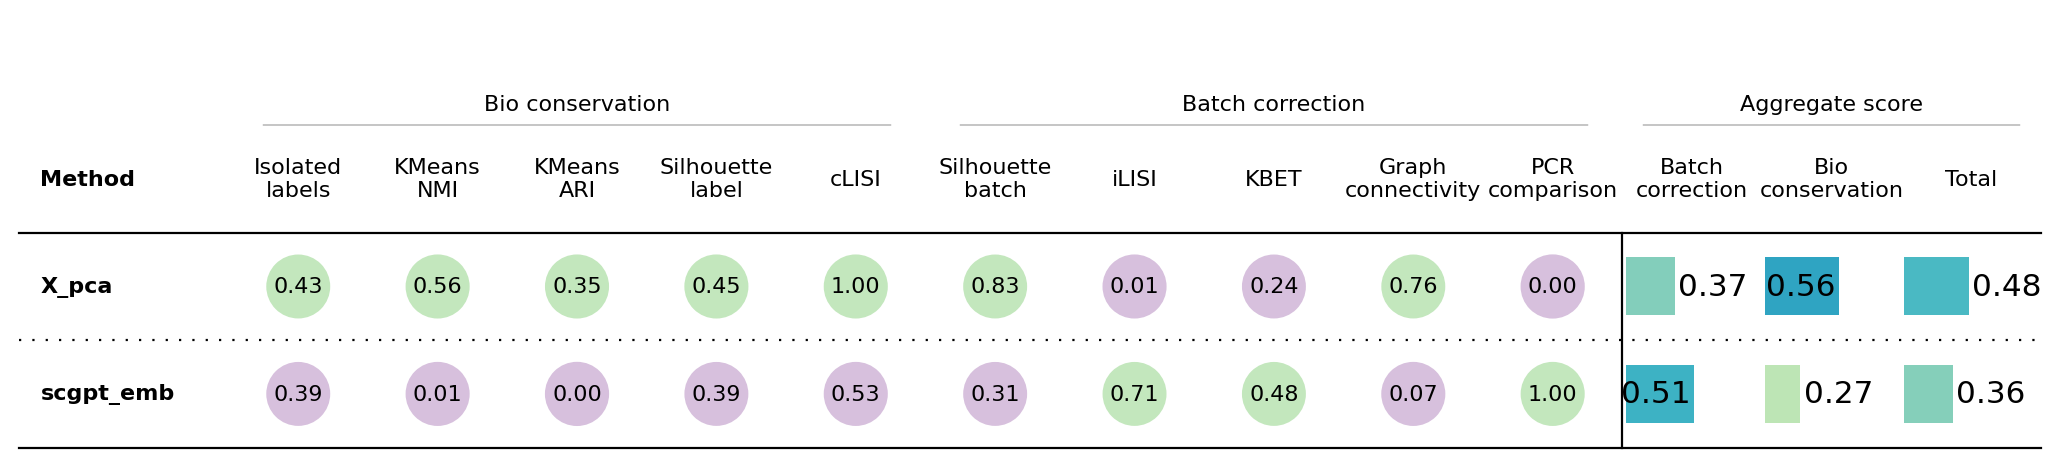

In [27]:
# lung (genes mean)
bm.plot_results_table(min_max_scale=False)

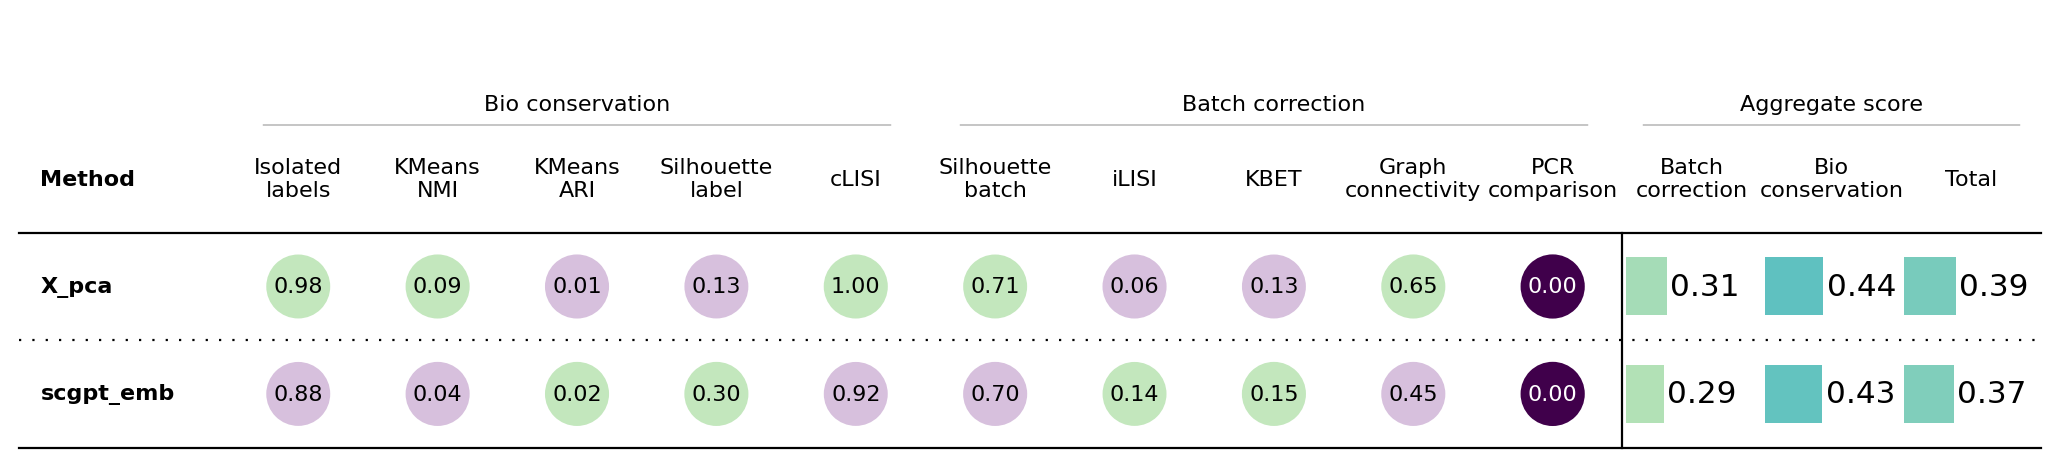

In [35]:
# panc
bm.plot_results_table(min_max_scale=False)